## Figures for thesis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import json
import glob

In [2]:
# directory management
wdir = os.getcwd()
udir = os.path.join(os.path.split(wdir)[0], "utils")
ddir = os.path.join(os.path.split(os.path.split(wdir)[0])[0], "fair_ml_thesis_data", "rawdata")
ddir2 = os.path.join(os.path.split(os.path.split(wdir)[0])[0], "fair_ml_thesis_data", "aggregated")
fdir = os.path.join(os.path.split(os.path.split(wdir)[0])[0], "fair_ml_thesis_figures")
if not os.path.exists(fdir):
  # Create a figures directory because it does not exist
  os.makedirs(fdir)
  print("Figures directory has been created!")

json_file_path = os.path.join(udir,'tasks_metadata.json')
with open(json_file_path, 'r') as j:
    task_infos = json.loads(j.read())

### Prepare task specific aggregated files if not existent already

In [3]:
data_fn = {}

for task in task_infos["task_names"]:
    data_fn[task] = {}
    for year_path in glob.iglob(f'{ddir}\*'):
        data_fn[task][str(os.path.split(year_path)[1])] = []
        year_path_1year = year_path + r'\1-Year'
        for state_path in glob.iglob(f'{year_path_1year}\*'):
            if state_path.endswith(f"{task}.csv"):
                data_fn[task][str(os.path.split(year_path)[1])].append(state_path)


### Explore frequency of NaN values and possible ways of recoding them

In [10]:
df = pd.read_csv(data_fn['ACSHealthInsurance']['2014'][0])
df['RAC1P'] = df[['RACAIAN', 'RACASN','RACBLK', 'RACNH', 'RACPI', 'RACSOR', 'RACWHT']].idxmax(axis=1)
race_codes = {'RACAIAN':5, 'RACASN':6, 'RACBLK':2, 'RACNH':7, 'RACPI':7, 'RACSOR':8, 'RACWHT':1}
df['RAC1P'] = df['RAC1P'].map(race_codes)
df.drop(['RACAIAN', 'RACASN','RACBLK', 'RACNH', 'RACPI', 'RACSOR', 'RACWHT'], axis=1, inplace=True)
df.head(20)

,Unnamed: 0,AGEP,SCHL,MAR,SEX,DIS,ESP,CIT,MIG,MIL,...,NATIVITY,DEAR,DEYE,DREM,PINCP,ESR,ST,FER,HINS2,RAC1P
0,0,30.0,19.0,1.0,2.0,2.0,0.0,4.0,1.0,4.0,...,2.0,2.0,2.0,2.0,900.0,6.0,2.0,2.0,0.0,1
1,1,34.0,20.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,...,1.0,2.0,2.0,2.0,49760.0,1.0,2.0,0.0,0.0,1
2,2,7.0,3.0,5.0,2.0,2.0,2.0,1.0,1.0,0.0,...,1.0,2.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,1
3,3,5.0,2.0,5.0,1.0,2.0,2.0,1.0,1.0,0.0,...,1.0,2.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,1
4,4,4.0,1.0,5.0,2.0,2.0,2.0,1.0,1.0,0.0,...,1.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,1
5,5,52.0,19.0,1.0,2.0,2.0,0.0,1.0,1.0,4.0,...,1.0,2.0,2.0,2.0,900.0,6.0,2.0,0.0,0.0,1
6,6,52.0,19.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,...,1.0,2.0,2.0,2.0,60900.0,1.0,2.0,0.0,0.0,1
7,7,28.0,18.0,5.0,1.0,2.0,0.0,1.0,1.0,4.0,...,1.0,2.0,2.0,2.0,1900.0,1.0,2.0,0.0,0.0,1
8,8,38.0,21.0,1.0,2.0,2.0,0.0,1.0,1.0,4.0,...,1.0,2.0,2.0,2.0,105000.0,1.0,2.0,2.0,0.0,1
9,9,38.0,18.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,...,1.0,2.0,2.0,2.0,140000.0,1.0,2.0,0.0,0.0,1


### Create files for the three tasks concatenating all states and years

In [10]:
for task in task_infos["task_names"]:

    if not os.path.exists(os.path.join(ddir2, task)):
        print(f"Preparing task {task}")
        os.makedirs(os.path.join(ddir2, task))
        print(f"Folder for aggregated task data {os.path.join(ddir2, task)} created!")
        dfs = []
        for year_to_plot in task_infos["years"]:
            all_dfs = []
            for data_path in data_fn[task][str(year_to_plot)]:
                state_df = pd.read_csv(data_path,sep=',',header=0)
                state_df['STATE'] = os.path.split(data_path)[1][5:7]
                all_dfs.append(state_df)
            year_df = pd.concat(all_dfs, ignore_index=True)
            year_df['YEAR']=int(year_to_plot)
            dfs.append(year_df)

    final_df = pd.concat(dfs, ignore_index=True)
    final_df.to_csv(os.path.join(ddir2, task,f'{task}.csv'),sep='\t')

Preparing task ACSEmployment
Folder for aggregated task data C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis_data\aggregated\ACSEmployment created!
Preparing task ACSHealthInsurance
Folder for aggregated task data C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis_data\aggregated\ACSHealthInsurance created!
Preparing task ACSIncome
Folder for aggregated task data C:\Users\sarab\Desktop\Data_Science_MSc\master_thesis\fair_ml_thesis_data\aggregated\ACSIncome created!


ValueError: No objects to concatenate

## Plots

### Distribution of age across states for each year

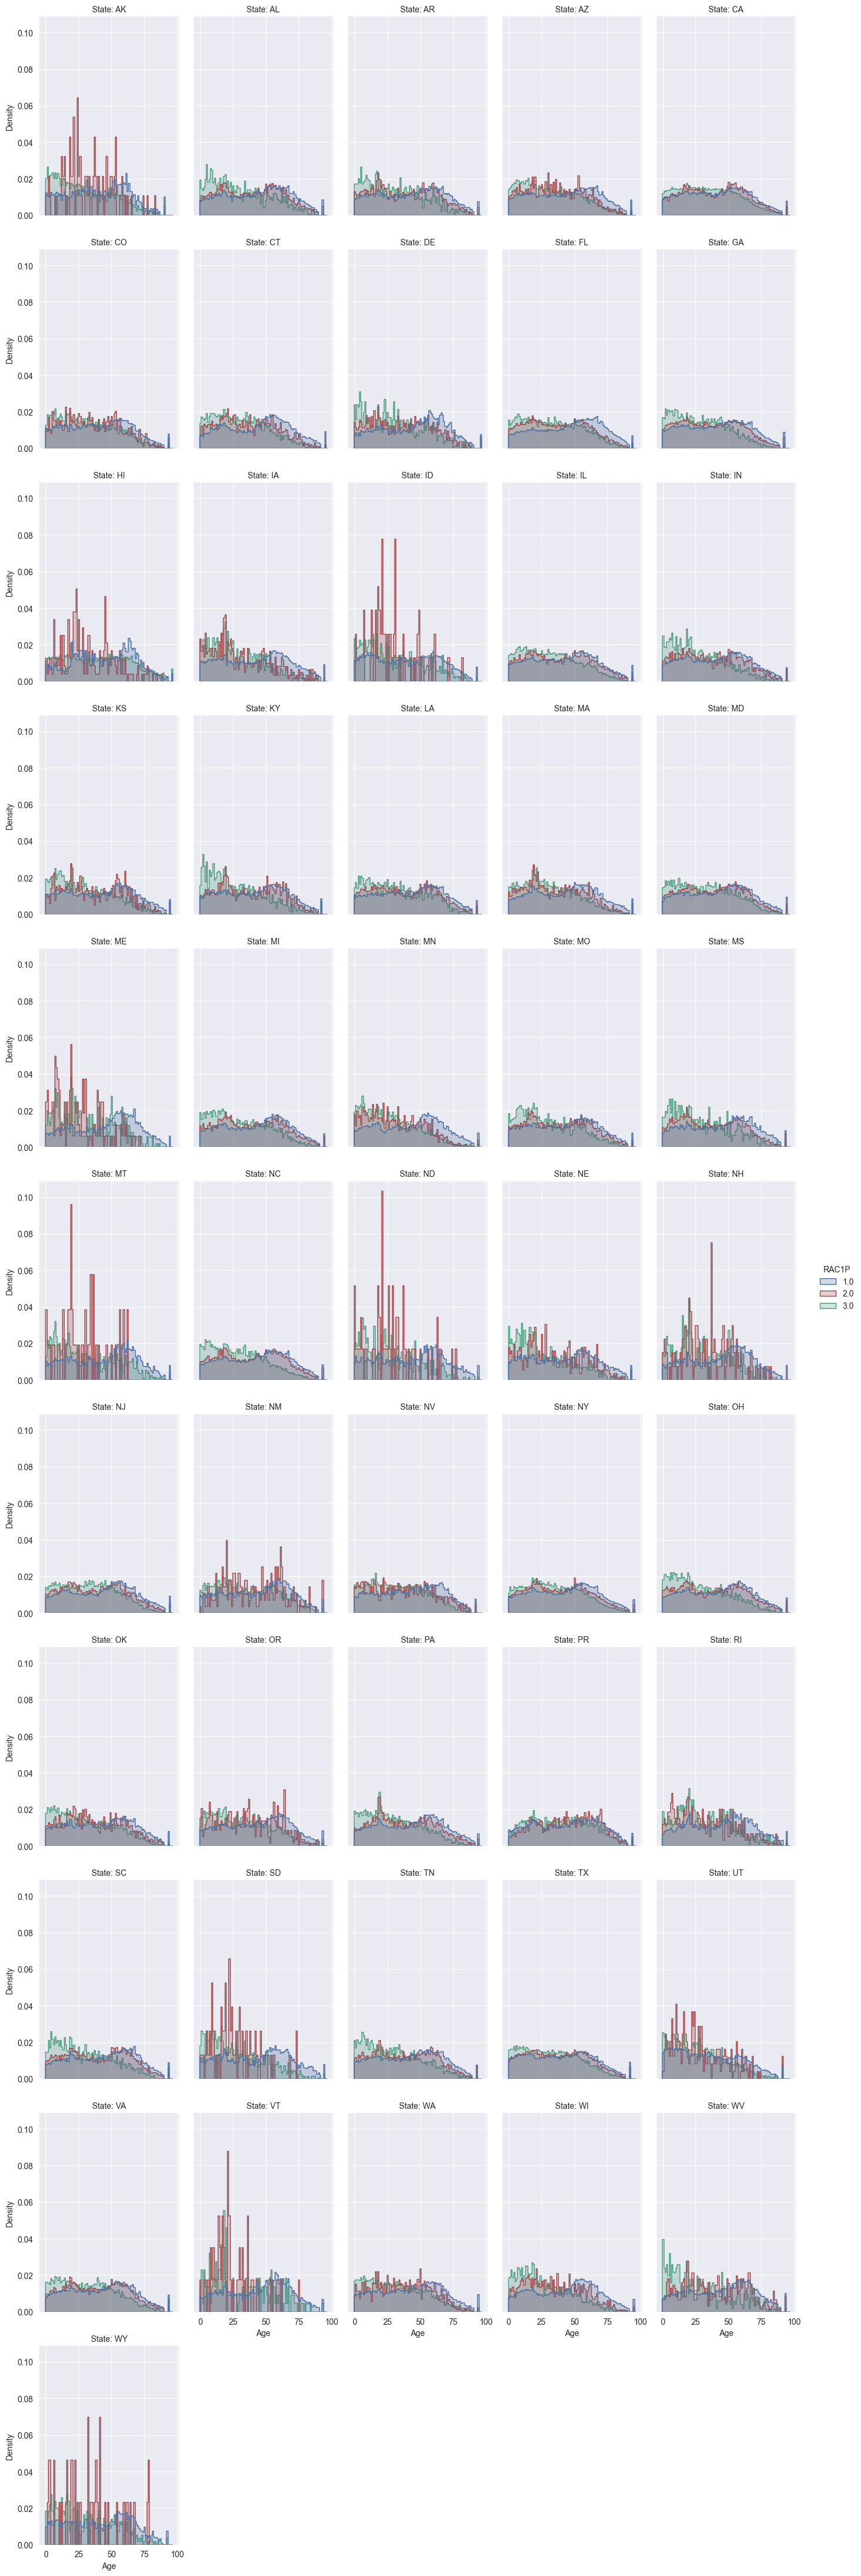

In [25]:
task='ACSEmployment'
df1 = pd.read_csv(os.path.join(ddir2,task,f'{task}.csv'),sep='\t',index_col=0)

y=2014
df1=df1[df1['YEAR']==y]
df1.loc[df1['RAC1P'] > 2, 'RAC1P'] = 3

g = sns.displot(data=df1, x="AGEP", hue="RAC1P", col="STATE",col_wrap=5,bins=10,
    kind="hist",element="step",discrete=True,stat='density',common_norm=False,
                legend=True, height=4, aspect=.7,palette= ['#476C9B','#984447','#469978'])
g.set_axis_labels("Age","Density")
g.set_titles("State: {col_name}")
plt.savefig(os.path.join(fdir,task,f'AGEP_distribution_dependent_on_RAC1P_{task}_{y}.pdf'),format='pdf',dpi=300)

### Class counts as a function of sex and race over the years - ACSEmployment

C:\Users\sarab\AppData\Local\Temp\ipykernel_13532\3782605189.py:3: DtypeWarning: Columns (23,27) have mixed types. Specify dtype option on import or set low_memory=False.
  task_data = pd.read_csv(os.path.join(ddir2, task, f"{task}.csv"),sep="\t")


KeyError: 'RAC1P'

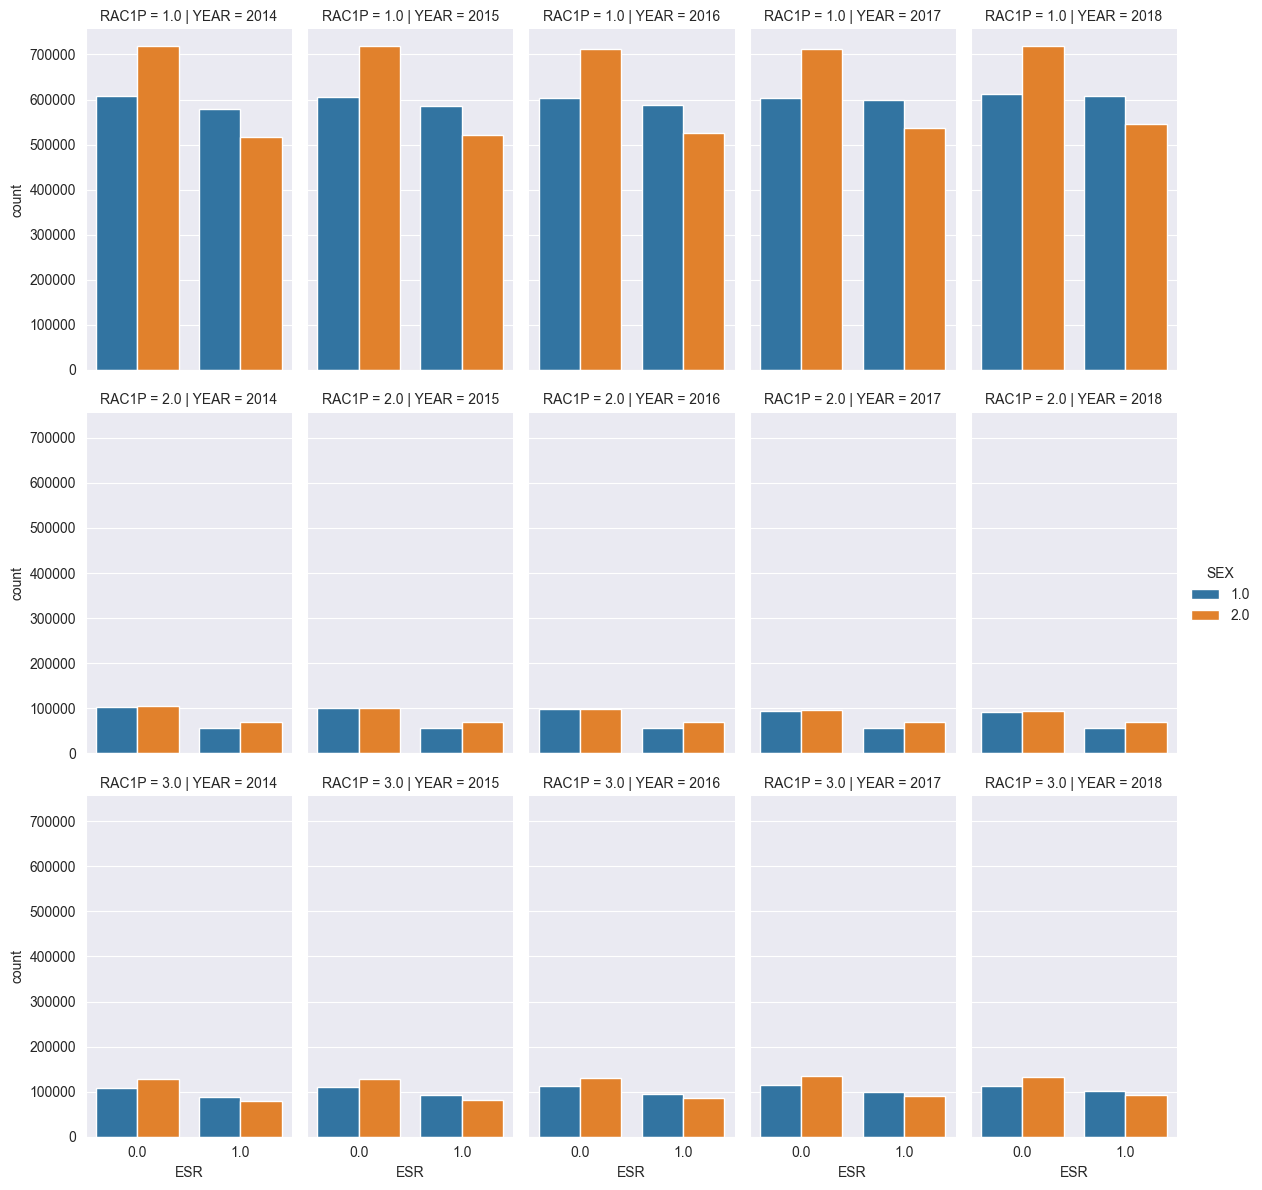

In [12]:
# create a plot for all states
for task in task_infos["task_names"]:
    task_data = pd.read_csv(os.path.join(ddir2, task, f"{task}.csv"),sep="\t")
    task_data.loc[task_data['RAC1P']>2,'RAC1P']=3
    sns.catplot(data=task_data, x="ESR", hue="SEX",row="RAC1P", col="YEAR",kind="count", height=4, aspect=.6)

### Class counts as a function of sex and race over the years - ACSIncome

In [25]:

df = pd.read_csv(data_fn['ACSIncome']['2014'][0],index_col=[0])
for c in ['COW','SCHL','MAR','POBP','RELP','SEX','RAC1P','PINCP']:
    df[c] = df[c].astype(np.int64)
df.head(20)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,34.0,1,20,1,1550.0,41,1,40.0,1,1,0
1,52.0,3,19,1,4220.0,39,1,40.0,1,1,1
2,28.0,1,18,5,6260.0,18,2,18.0,1,1,0
3,38.0,1,21,1,136.0,8,0,45.0,2,1,1
4,38.0,1,18,1,600.0,8,1,40.0,1,1,1
5,60.0,1,16,5,6100.0,2,0,40.0,2,9,1
6,38.0,1,21,5,5240.0,53,0,50.0,1,1,1
7,37.0,2,17,5,3300.0,53,13,40.0,2,1,0
8,51.0,1,16,5,4760.0,41,17,60.0,1,1,1
9,58.0,3,16,1,6320.0,2,0,12.0,1,4,0
